In [1]:
import pandas as pd

In [2]:
# Import the data
ppi_clean = pd.read_csv('./data/ppi_clean_train.csv')

In [3]:
# Remove columns that shouldn't be features
def remove_non_features(df: pd.DataFrame, non_feature_cols: list[str]) -> pd.DataFrame:
    return df.drop(non_feature_cols, axis=1)

In [4]:
# Split data into train/validation and test set, taking into account the protein groups
from sklearn.model_selection import GroupShuffleSplit

def split_data_by_group(X: pd.DataFrame, y: pd.Series, groups: pd.Series, **kwargs) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    gss = GroupShuffleSplit(**kwargs)

    for train_idx, test_idx in gss.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

    assert set(X_train.uniprot_id).intersection(set(X_test.uniprot_id)) == set(), 'The same uniprot ID appears in both the train and test set!'
    return X_train, X_test, y_train, y_test

def select_window_size(df: pd.DataFrame, window_sizes) -> pd.DataFrame:
    '''Remove the window columns that are not used, i.e. not specified in window_size'''
    keep_cols = set()
    wm_cols = df.columns[df.columns.str.match(r"^\d+_wm")].tolist()
    all_cols = set(wm_cols)

        # Regex for [number]_wm
      #pssm_cols = [col for col in df.columns if col.startswith('pssm') or col.startswith('prob')]
      #extra_cols = ['rel_surf_acc', 'normalized_abs_surf_acc', 'normalized_hydropathy_index']
      
    for window_size in window_sizes:
        keep_cols.update(set([col for col in df.columns if col.startswith(f"{window_size}_wm")]))



    cols_to_remove = list(set(all_cols).difference(set(keep_cols)))
    cols_before = frozenset(df.columns)
    df = df.drop(cols_to_remove, axis=1)
    cols_after = frozenset(df.columns)
    
    return df

In [5]:
from itertools import combinations
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from xgboost import XGBClassifier

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GroupKFold
from sklearn.base import BaseEstimator
from sklearn.metrics import roc_auc_score, recall_score

def kfold_cv_by_group(X: pd.DataFrame, y: pd.Series, groups: pd.Series, model: BaseEstimator, **kwargs) -> pd.DataFrame:
    group_kfold = GroupKFold(**kwargs)

In [7]:
from sklearn.ensemble import RandomForestClassifier
import os.path

In [8]:
result_file = 'result_window_selection'

In [9]:
y = ppi_clean.p_interface
X_non_windowed = ppi_clean.drop('p_interface', axis=1)
non_feature_cols = ['domain', 'aa_ProtPosition', 'uniprot_id']
X_non_windowed = remove_non_features(X_non_windowed, non_feature_cols)
groups = ppi_clean.uniprot_id
gs_model = RandomForestClassifier(class_weight='balanced')

gs_params = {
    'max_depth': list(range(5, 51)),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf': list(range(1, 73, 2)),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': list(range(5, 301, 5))
}
if not os.path.exists(f'./data/{result_file}.csv'):
    gridsearch = BayesSearchCV(gs_model, gs_params, n_jobs=-1, scoring='roc_auc', cv=GroupKFold())
    dict_results = {'size': [], 'windows': [], 'best_params': [], 'best_score': [], 'stdev': []}
    for size in [0,1,2,3,4]:
        print(f'Running {size=}...')
        for selection in combinations(set([3,5,7,9]), size):
            print(f'Running {selection=}')
            X = select_window_size(X_non_windowed, list(selection))
            gridsearch.fit(X, y, groups=groups)
            dict_results['size'].append(size)
            dict_results['windows'].append(selection)
            dict_results['best_params'].append(gridsearch.best_params_)
            dict_results['best_score'].append(gridsearch.best_score_)
            dict_results['stdev'].append(gridsearch.cv_results_['std_test_score'][gridsearch.best_index_])
            
    hyperparam_results = pd.DataFrame(dict_results)
    hyperparam_results.to_csv(f'./data/{result_file}.csv', index=False)
else:
    hyperparam_results = pd.read_csv(f'./data/{result_file}.csv')

print(hyperparam_results)


    size       windows                                        best_params  \
0      0            ()  OrderedDict({'criterion': 'gini', 'max_depth':...   
1      1          (9,)  OrderedDict({'criterion': 'gini', 'max_depth':...   
2      1          (3,)  OrderedDict({'criterion': 'log_loss', 'max_dep...   
3      1          (5,)  OrderedDict({'criterion': 'gini', 'max_depth':...   
4      1          (7,)  OrderedDict({'criterion': 'log_loss', 'max_dep...   
5      2        (9, 3)  OrderedDict({'criterion': 'gini', 'max_depth':...   
6      2        (9, 5)  OrderedDict({'criterion': 'log_loss', 'max_dep...   
7      2        (9, 7)  OrderedDict({'criterion': 'entropy', 'max_dept...   
8      2        (3, 5)  OrderedDict({'criterion': 'gini', 'max_depth':...   
9      2        (3, 7)  OrderedDict({'criterion': 'entropy', 'max_dept...   
10     2        (5, 7)  OrderedDict({'criterion': 'gini', 'max_depth':...   
11     3     (9, 3, 5)  OrderedDict({'criterion': 'entropy', 'max_dept...   

In [10]:
display(hyperparam_results)

,size,windows,best_params,best_score,stdev
0,0,(),"OrderedDict({'criterion': 'gini', 'max_depth':...",0.673742,0.036955
1,1,"(9,)","OrderedDict({'criterion': 'gini', 'max_depth':...",0.697054,0.035446
2,1,"(3,)","OrderedDict({'criterion': 'log_loss', 'max_dep...",0.685291,0.036993
3,1,"(5,)","OrderedDict({'criterion': 'gini', 'max_depth':...",0.687803,0.037508
4,1,"(7,)","OrderedDict({'criterion': 'log_loss', 'max_dep...",0.693364,0.036154
5,2,"(9, 3)","OrderedDict({'criterion': 'gini', 'max_depth':...",0.697112,0.034261
6,2,"(9, 5)","OrderedDict({'criterion': 'log_loss', 'max_dep...",0.694904,0.035036
7,2,"(9, 7)","OrderedDict({'criterion': 'entropy', 'max_dept...",0.695406,0.032588
8,2,"(3, 5)","OrderedDict({'criterion': 'gini', 'max_depth':...",0.688056,0.035372
9,2,"(3, 7)","OrderedDict({'criterion': 'entropy', 'max_dept...",0.692785,0.035884


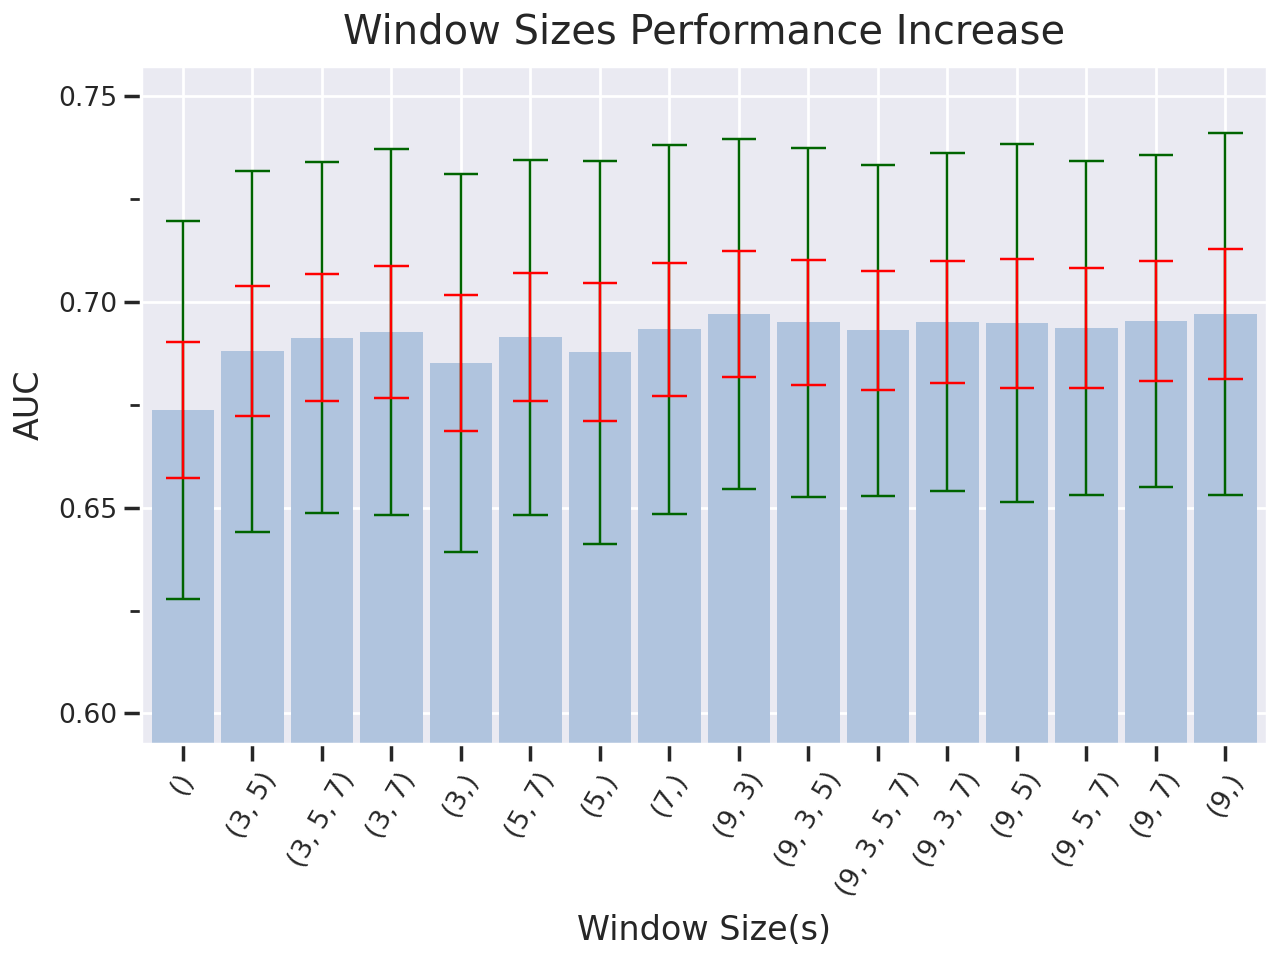

In [75]:
from plotnine import ggplot, aes, geom_bar, geom_errorbar, labs, theme_seaborn, coord_cartesian, theme, element_text

def plot_window_performance(df: pd.DataFrame, best_score_metric: str, title: str, n_folds: int=5) -> None:
	import scipy.stats as stats
	confidence = 0.95
	t_critical = stats.t.ppf((1 + confidence) / 2, df=n_folds - 1)
	df = df.rename({'best_score': best_score_metric}, axis=1)

	df['SEM'] = df['stdev'] / n_folds**0.5
	df['CI'] = t_critical * df['SEM']

	# Create ggplot
	p = (
		ggplot(df, aes(x='windows', y=best_score_metric)) +
		geom_bar(stat='identity', position='dodge', show_legend=True, fill='LightSteelBlue') +  # Bar plot
		labs(title=title, y=best_score_metric.upper(), x='Window Size(s)') +
		geom_errorbar(aes(ymin=f'{best_score_metric} - CI', ymax=f'{best_score_metric} + CI'), color='darkgreen') +
		geom_errorbar(aes(ymin=f'{best_score_metric} - SEM', ymax=f'{best_score_metric} + SEM'), color='red') +
		coord_cartesian(ylim=(0.6,0.75)) +
		theme_seaborn() +
		theme(axis_text_x=element_text(rotation=60, hjust=0.5))
	)

	display(p)

plot_window_performance(hyperparam_results, 'auc', 'Window Sizes Performance Increase')
# Performance increase is insignificant, however, performance is consistently better with window sizes
# This is possibly because no window size (or window size 1) encodes most of the valuable information (hence the insignificant increase)
# But the consistent higher score implies that there is some valuable information that the no window size does not have